In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [3]:
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [4]:
# input layer
input = layers.Input(shape=(32, 32, 3))

# convolutional layer
conv1 = layers.Conv2D(32, 3, activation='relu')(input)
pool1 = layers.MaxPooling2D((2, 2), 2)(conv1)

conv2 = layers.Conv2D(64, 3, activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2), 2)(conv2)

conv3 = layers.Conv2D(64, 3, activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2), 2)(conv3)

# flatten 
flat = layers.Flatten()(pool3)

# 5. Branch 1: Main classifier
main_branch = layers.Dense(256, activation='relu')(flat)
main_output = layers.Dense(10, activation='softmax', name="main_output")(main_branch)

# 6. Branch 2: Auxiliary classifier (helps gradient flow, regularization)
aux_branch = layers.Dense(128, activation='relu')(flat)
aux_output = layers.Dense(10, activation='softmax', name="aux_output")(aux_branch)


In [5]:
model = models.Model(inputs=input, outputs=[main_output, aux_output])


In [11]:
model.compile(
    optimizer='adam',
    loss={
        'main_output': 'sparse_categorical_crossentropy',
        'aux_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'main_output': 1.0, 'aux_output': 0.3},
    metrics={
        'main_output': 'accuracy',
        'aux_output': 'accuracy'
    }
)


In [12]:
plot_model(model, show_shapes=True, dpi=80)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 2, 64)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 10)        │      2,570 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_output (Dense)  │ (None, 10)        │      1,290 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 158,868 (620.58 KB)

 Trainable params: 158,868 (620.58 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, {"main_output": y_train, "aux_output": y_train},
    validation_data=(X_test, {"main_output": y_test, "aux_output": y_test}),
    epochs=10,
    batch_size=64
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - aux_output_accuracy: 0.4097 - aux_output_loss: 1.6050 - loss: 2.0737 - main_output_accuracy: 0.4165 - main_output_loss: 1.5919 - val_aux_output_accuracy: 0.5316 - val_aux_output_loss: 1.3125 - val_loss: 1.6994 - val_main_output_accuracy: 0.5373 - val_main_output_loss: 1.3042
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - aux_output_accuracy: 0.5681 - aux_output_loss: 1.2210 - loss: 1.5744 - main_output_accuracy: 0.5723 - main_output_loss: 1.2085 - val_aux_output_accuracy: 0.6058 - val_aux_output_loss: 1.1115 - val_loss: 1.4323 - val_main_output_accuracy: 0.6100 - val_main_output_loss: 1.0982
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - aux_output_accuracy: 0.6298 - aux_output_loss: 1.0541 - loss: 1.3570 - main_output_accuracy: 0.6359 - main_output_loss: 1.0402 - val_aux_output_accuracy: 0.6377 - val_aux_output_loss: 1.0215 - val_loss: 1.3152 - val_main_output_accuracy: 0.6443 - val_main_output_loss: 1.0078
Epoc

In [15]:
results = model.evaluate(X_test, {"main_output": y_test, "aux_output": y_test})
print("Test Results:", results)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - aux_output_accuracy: 0.7128 - aux_output_loss: 0.8492 - loss: 1.0857 - main_output_accuracy: 0.7194 - main_output_loss: 0.8308
Test Results: [1.0856674909591675, 0.830785870552063, 0.8492028713226318, 0.7128000259399414, 0.7193999886512756]


In [21]:
for key, value in history.history.items():
    value = np.max(value) if 'accuracy' in key else np.min(value)
    print(f"{key} : {value}")


aux_output_accuracy : 0.7714200019836426
aux_output_loss : 0.6541822552680969
loss : 0.8118489980697632
main_output_accuracy : 0.7833399772644043
main_output_loss : 0.6151970028877258
val_aux_output_accuracy : 0.7128000259399414
val_aux_output_loss : 0.8485666513442993
val_loss : 1.0755329132080078
val_main_output_accuracy : 0.7193999886512756
val_main_output_loss : 0.8189207315444946


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


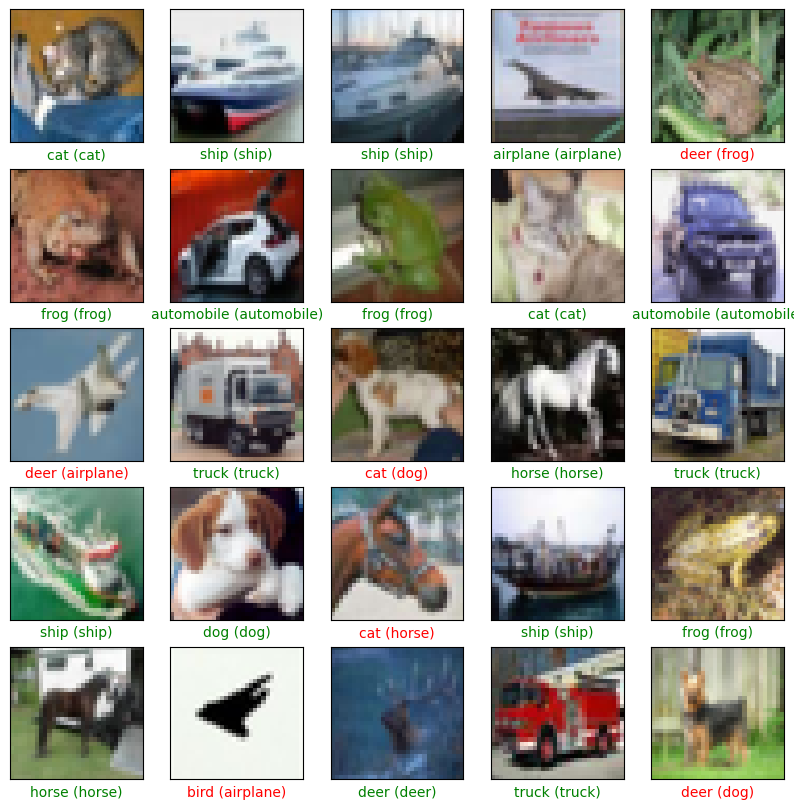

In [16]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predictions = model.predict(X_test[:25])
# We'll use output1 predictions (you can change to output2 if needed)
output1_predictions = predictions[0]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i])
    idx = np.argmax(output1_predictions[i])
    pred_label = class_names[idx]
    true_label = class_names[int(y_test[i])]
    color = 'green' if pred_label == true_label else 'red'
    plt.xlabel(f"{pred_label} ({true_label})", color=color)
plt.show()